# Setup

In [1]:
#JJMF 20230201 
# We changed the folder paths
# We tried to save the loss and val_loss results for every iteration, both the complete history and the best values
# We created version create_datasetV9 that includes the option of a seed to generate the same data set for all the 10
# trainings, then used it here
seedCreateDatasetV9 = 41 #+ umber of trained, added later in the code
# This way we provide 10 different datasets to the methods, but the same 10 
# We included the value of batch size
# We give the best model to the test final part
# LR is used when calling to optimization

# 20230305 JJMF We forgot to set the LR to a fixed rate... we rerun it with LR = 1.0e-3 y dropout a 0 and

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)
import os
sys.path.append(os.getcwd()+'/../Utils')

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
import scipy

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Functions and Regression models:
from RegressionModelsV5gh import *
from preprocess_countV14gh import *

import time
'''
if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
'''


#JJMF 20230324 code is available for NVIDIA GPU 
CUDA_VISIBLE_DEVICES=0 #./cuda_executable
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0


# Para limpiar la memoria de la GPU entre iteraciones
import tensorflow.keras.backend as K
import gc
import nvidia_smi
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

# to make this notebook's output stable across runs
from datetime import datetime
from time import perf_counter


#JJMF 20230324 In our setup we have a list of X-ray of canvases and here we indicate which one
#to use in each subdataset. For each image we have about 7-10 samples labeled. Labeling consist 
#of polygons around each thread
trainImages = [0,2,3,6,5,5,8,8,10,10,12,12,13,13,15,16,16,17,17,18,18,20,20,21,21,22,22,
               23,24,24,25,26,27,28,28,29,30,31,32,33,34,35,36]
validImages = [4, 4, 9, 9, 1, 1, 14]
testImages = [11, 7, 19]

numberRotations = 1 ##JJMF 20230324 indicate how many rotations are included in Data Augmentation (DA)
Elastic = False #JJMF 20230324 if elastic deformations is used in Data Augmentation (DA)

from keras import backend as K


##JJMF 20230324 We define our function loss
def normalizedRMSE(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)/y_true, axis=-1)) 
    
def normalizedMSE(y_true, y_pred):
        return (K.mean(K.square(y_pred - y_true)/y_true, axis=-1)) 

def normalizedMAE(y_true, y_pred):
        return K.mean(K.abs(y_pred - y_true)/y_true, axis=-1) 
    
##JJMF 20230324 indicate paths
folderIPYNB =  os.path.abspath(os.getcwd())
folderCrops = folderIPYNB + '/../Utils/cropsVentanaREG/' #JJMF 20230324 paths where original pre-processed images are                                                       
### Folder with npz files path:
folderNPZ = folderIPYNB + '/../Utils/LabeledNEv7_npz/' #JJMF 20230324 binary images with location of crossing points
folderSave = folderIPYNB+ '/Trained_models/VGGEqNMAEBS32/' ##JJMF 20230324 folder to save learnt weights of the model

#path = os.path.dirname(saveFileName)
if not os.path.exists(folderSave):
    os.makedirs(folderSave)
    
#Model
numberOfFilters = 8
pbDroput = 0.05
lossFunc = 'mse'
nameModel2Save ='RegressionVGG'  ##JJMF 20230324 name of the model used, see RegressionModelsV6gh.py 
es = EarlyStopping(monitor='val_loss', mode='min', patience = 10) #patience=65)    
EPOCHS = 100 #450
LR = 1.0e-3
seedCreateDatasetV9 = 41
numberOfTrainings = 2 #10 #JJMF 20230324 Important, the number of different learning of the model
         #with different DA and initialization of the weights. If you reuse the code for other model
         #you will see that the DA generated for every training is the same, by using a different seed 
         #given by seedCreateDatasetV9+l with l the number of the train.
BatchSize = 32 

def lr_time_based_decay(epoch, learning_rate):
    return LR #* 1 / (1 + epoch/10) #JJMF 20230324  fixed rate
sch = LearningRateScheduler(lr_time_based_decay, verbose=1)
modelFunc = 'regVGG(input_shape = (200,200,1), numFilters = numberOfFilters, dropout = pbDroput)'

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


2023-03-24 13:44:33.721930: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-03-24 13:44:34.241642: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46713 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:1a:00.0, compute capability: 8.6


# Preparing the Data (images)

In [3]:
#JJMF 20230324 In forlder folderNPZ we have .npz files with labels named CropsXXXX.npz. In folderNPZ we will have a list of files, one per laTherefore the m x 40 points + n with 0<=n<=40 points to the 
#labels for m-th canvas, XXXX. But as we generate just some labels out of 40 the 
# samples taken from each canvas, we do not have a complete continuous list of images. For example, if we labeled sample 
# 0, 3, 7, 34, 83, 94, 97, 102, 104, in the folder you will find files Crops0000.npz, Crops0003.npz, Crops0034.npz, Crops0083.npz,
# and so on, corresponding to canvases number 0 and 3. The corresponding input images will be also used, taken from
# folderCrops 
#
#In this cell we generate the indexes to the samples (labels and images), and generate three list of indexs for training,
#validation and test. Images are 1.5 cm side and 200 px per cm, therefore 300 pixels side square images.

print(folderNPZ)
# Alphabetically ordered list:
os.chdir(folderNPZ)
content = os.listdir(folderNPZ)
content.sort()
os.chdir('..')
os.chdir('..')

# Remove .DS_Store file if exists:
if content[0] == '.DS_Store':
    content.pop(0)
    
# We read those crops that have been labeled (Crops name are duplicated since there are two npz files for each crop)
listCropsLabeled = []
listCropsLabeledNumber = []

for crop in content:
    listCropsLabeled.append(crop[:-6])  #JJMF we remove _H.npz or _V.npz to get the crop name
    listCropsLabeledNumber.append(int(crop[4:-6]))

    
listCropsLabeled = list(set(listCropsLabeled)) #JJMF We get the unique names, i.e. remove repeated names
listCropsLabeled.sort()
listCropsLabeledNumber = list(set(listCropsLabeledNumber))
listCropsLabeledNumber.sort()


# Number of different labeled crops at the list
numberOfLabels = len(listCropsLabeled)
print('Number of read patches:{}'.format(numberOfLabels )) 

# Number of patches obtained from each image
numberPatchesPerImage = 40  # Fixed on notebook "newCropImagesOO"
print('Number of read patches generated per image:{}'.format(numberPatchesPerImage)) 
    
idxOfImg = (np.asarray(listCropsLabeledNumber)-1) // numberPatchesPerImage #//40

#JJMF 20200306 This is important to know how many labeled patches of every image do we have.
vl,labelsPerImages = np.unique(idxOfImg, return_counts=True)

#JJMF 20200303 
#We need to know what label belong to what image

indexCanvas = []
auxCanvas = []
prev = idxOfImg[0]
canvasMapNumber = []
labelsPerImage =[]
for k1 in range(numberOfLabels):
    

    if idxOfImg[k1] != prev:
        indexCanvas.append(auxCanvas)
        labelsPerImage.append(len(auxCanvas))
        for k2 in range(idxOfImg[k1]-prev-1):
                indexCanvas.append([])
                labelsPerImage.append(0)
        auxCanvas = []
        canvasMapNumber.append(prev)
        prev = idxOfImg[k1]
    
    auxCanvas.append(listCropsLabeled[k1])
    
    
#JJMF 20220307    
#At exit of for we need to save the labels for the last image             
indexCanvas.append(auxCanvas)
labelsPerImage.append(len(auxCanvas))
canvasMapNumber.append(prev)
    
indexCanvas=list(indexCanvas)


#JJMF 20230324 generate indexes to the samples for every data subset
#Complete list of images
idxImgs = np.asarray(trainImages+validImages+testImages)
#len(idxImgs)

trainLen = len(trainImages)
validLen = len(validImages)
testLen = len(testImages)

print('Images with some labeled crops:',canvasMapNumber,'\n')
print('Number of labels per image:', labelsPerImage)

print('Labeled Crops for every Images:')
indexCanvas

/home/murillo/Dropbox/MNP/LIDIAgithub/RegressionNMAE/../Utils/LabeledNEv7_npz/
Number of read patches:240
Number of read patches generated per image:40
Images with some labeled crops: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36] 

Number of labels per image: [7, 7, 8, 10, 8, 7, 11, 4, 10, 6, 11, 8, 10, 5, 10, 7, 12, 4, 7, 6, 10, 10, 5, 5, 4, 5, 5, 5, 4, 3, 3, 2, 4, 4, 3, 5, 5]
Labeled Crops for every Images:


[['Crop0012',
  'Crop0013',
  'Crop0015',
  'Crop0022',
  'Crop0028',
  'Crop0031',
  'Crop0036'],
 ['Crop0041',
  'Crop0058',
  'Crop0062',
  'Crop0065',
  'Crop0073',
  'Crop0074',
  'Crop0080'],
 ['Crop0081',
  'Crop0084',
  'Crop0087',
  'Crop0088',
  'Crop0097',
  'Crop0101',
  'Crop0102',
  'Crop0104'],
 ['Crop0123',
  'Crop0125',
  'Crop0126',
  'Crop0132',
  'Crop0139',
  'Crop0145',
  'Crop0147',
  'Crop0152',
  'Crop0156',
  'Crop0159'],
 ['Crop0165',
  'Crop0170',
  'Crop0175',
  'Crop0178',
  'Crop0184',
  'Crop0187',
  'Crop0192',
  'Crop0195'],
 ['Crop0201',
  'Crop0212',
  'Crop0219',
  'Crop0221',
  'Crop0223',
  'Crop0226',
  'Crop0236'],
 ['Crop0243',
  'Crop0244',
  'Crop0245',
  'Crop0247',
  'Crop0249',
  'Crop0250',
  'Crop0253',
  'Crop0272',
  'Crop0274',
  'Crop0275',
  'Crop0277'],
 ['Crop0299', 'Crop0302', 'Crop0307', 'Crop0315'],
 ['Crop0321',
  'Crop0322',
  'Crop0323',
  'Crop0324',
  'Crop0325',
  'Crop0326',
  'Crop0327',
  'Crop0328',
  'Crop0329',
  'C

# ANN MODEL

In [4]:
model = eval(modelFunc)
model.compile(optimizer = Adam(learning_rate = LR), loss = lossFunc)

2023-03-24 13:44:34.487794: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46713 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:1a:00.0, compute capability: 8.6


In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 200, 200, 8)  80          ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 200, 200, 8)  208         ['input_1[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 200, 200, 8)  400         ['input_1[0][0]']            

In [6]:
# Get the UNET model you want:
input_img = Input((im_height, im_width, 1), name='img')

lossVal=[]
lossTrain=[]
timeIterData=[]
timeIterTrain=[]

for k2 in range(numberOfTrainings):
    print('\n NUMBER OF TRAINING', k2+1)    
    start = perf_counter()

    
    #JJMF 20230324 Randomness is an important issue here. In function create_datasetV10 we have seed as argument. If we use the same
    #seed the same DA dataset will be generated. Otherwise the seed is ramdomized in the following lines. 
    
    # Random seed
    random.seed(datetime.now().microsecond)
    np.random.seed(datetime.now().microsecond)
    tf.random.set_seed(datetime.now().microsecond)

    # CREATING DATASET
    X_rot_train_full, aux_rot_train_full, dataAugmentationNumber, trainIdx, validIdx, testIdx = create_datasetV10(folderCrops, folderNPZ, idxImgs, 
                                            indexCanvas, labelsPerImage, trainImages, validImages, testImages, giro=False, seed=seedCreateDatasetV9+k2)

    #JJMF 20230324 labels are annotation in an image, indicating where crossing points are. We next compute the density of 
    #vertical threads from the annotated images
    # Generate count ground truth
    print('Generating counting labels... ')
    Y_train_full = np.zeros((len(aux_rot_train_full),1))
    for k1 in range(len(aux_rot_train_full)):
        Y_train_full[k1],_,_,_ = spatialCountingNeighborsv3(aux_rot_train_full[k1],pS=100,pI=0)
    del aux_rot_train_full

    end = perf_counter()
    execution_time = (end - start)
    print('Execution time in generating samples:{}'.format(execution_time)) 
    timeIterData.append(execution_time)    
    
    #TRAINING
    start = perf_counter()
    
    print('Instancing new model...')
    model = eval(modelFunc)
    model.compile(optimizer = Adam(learning_rate = LR), loss = normalizedMAE, metrics = normalizedMAE)
    mc = ModelCheckpoint(folderSave+nameModel2Save+'_'+str(k2)+'.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

    print('Training...')
    # Training...
    results = model.fit(X_rot_train_full[trainIdx], Y_train_full[trainIdx], epochs=EPOCHS, batch_size = BatchSize, shuffle=True, 
       validation_data=(X_rot_train_full[validIdx], Y_train_full[validIdx]),callbacks=[es, mc, sch])

    print('Cleaning GPU memory...')
    # Cleaning GPU memory
    K.clear_session()
    for i in range(50):
        gc.collect()  
    tf.compat.v1.reset_default_graph()
    
    del model, X_rot_train_full, Y_train_full
    
    #JJMF 20230324 We save history results
    nameResults=folderSave+nameModel2Save+'Hist_'+str(k2)+'.npy'
    np.save(nameResults,results.history)
    #historyLoaded=np.load('nameResults',allow_pickle='TRUE').item()
    
    minVal= min(results.history.get('val_loss'))
    idx = results.history.get('val_loss').index(minVal)
    minTrain=results.history.get('loss')[idx]
    lossVal.append(minVal)
    lossTrain.append(minTrain)   
    
    end = perf_counter()
    execution_time = (end - start)
    print('Execution time in Training:{}'.format(execution_time)) 
    timeIterTrain.append(execution_time)


 NUMBER OF TRAINING 1
Creating dataset...
Rotating 90º each 200x200 crop...
Converting to 0-1 range...
Generating counting labels... 
Execution time in generating samples:388.02500778000103
Instancing new model...
Training...

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100


2023-03-24 13:51:14.438567: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100
2023-03-24 13:51:16.220063: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-24 13:51:18.434006: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


762/762 [==============================] - ETA: 0s - loss: 0.1179 - normalizedMAE: 0.1179
Epoch 00001: val_loss improved from inf to 0.18332, saving model to /home/murillo/Dropbox/MNP/LIDIAgithub/RegressionNMAE/Trained_models/VGGEqNMAEBS32/RegressionVGG_0.h5
762/762 [==============================] - 87s 102ms/step - loss: 0.1179 - normalizedMAE: 0.1179 - val_loss: 0.1833 - val_normalizedMAE: 0.1833 - lr: 0.0010

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/100
762/762 [==============================] - ETA: 0s - loss: 0.0529 - normalizedMAE: 0.0529
Epoch 00002: val_loss improved from 0.18332 to 0.03666, saving model to /home/murillo/Dropbox/MNP/LIDIAgithub/RegressionNMAE/Trained_models/VGGEqNMAEBS32/RegressionVGG_0.h5
762/762 [==============================] - 76s 100ms/step - loss: 0.0529 - normalizedMAE: 0.0529 - val_loss: 0.0367 - val_normalizedMAE: 0.0367 - lr: 0.0010

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/100
762/

761/762 [============================>.] - ETA: 0s - loss: 0.0483 - normalizedMAE: 0.0483
Epoch 00002: val_loss did not improve from 0.03760
762/762 [==============================] - 76s 100ms/step - loss: 0.0483 - normalizedMAE: 0.0483 - val_loss: 0.0580 - val_normalizedMAE: 0.0580 - lr: 0.0010

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/100
761/762 [============================>.] - ETA: 0s - loss: 0.0391 - normalizedMAE: 0.0391
Epoch 00003: val_loss did not improve from 0.03760
762/762 [==============================] - 76s 100ms/step - loss: 0.0391 - normalizedMAE: 0.0391 - val_loss: 0.0474 - val_normalizedMAE: 0.0474 - lr: 0.0010

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/100
762/762 [==============================] - ETA: 0s - loss: 0.0356 - normalizedMAE: 0.0356
Epoch 00004: val_loss improved from 0.03760 to 0.01703, saving model to /home/murillo/Dropbox/MNP/LIDIAgithub/RegressionNMAE/Trained_models/VGGEqNMAEBS32/

In [9]:
#JJMF 20230324 We save the results of the train and validation loss and invested times
import pandas as pd
losses=np.c_[lossTrain, lossVal, timeIterData, timeIterTrain]
iterations=[]
for k2 in range(numberOfTrainings):
    iterations.append(str(k2))
df = pd.DataFrame(losses.T, columns = iterations) #['0','1','2','3','4','5','6','7','8','9'])

lossNames = ['lossTrain', 'lossVal', 'timeIterData', 'timeIterTrain']
df[nameModel2Save]=lossNames
df.set_index(nameModel2Save,inplace=True)
namePD=folderSave+nameModel2Save+'Losses'+'.csv'
df.to_csv(namePD)
df2=pd.read_csv(namePD)
df2

,RegressionVGG,0,1
0,lossTrain,0.026747,0.013485
1,lossVal,0.015926,0.010387
2,timeIterData,388.025008,393.679132
3,timeIterTrain,1396.748307,3133.612342


In [10]:
#JJMF 20230324 The selected weights are those for the train with lowest validation loss
bestTraining=np.argmin(losses[:,1])
print('Best Iteration: ',bestTraining) 

Best Iteration:  1


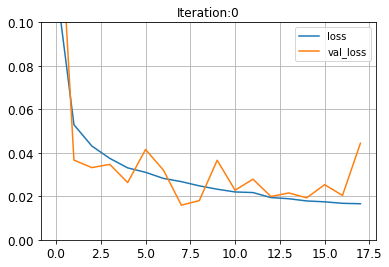

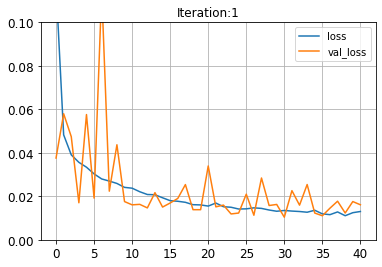

In [12]:
#JJMF 20230324 Load saved results and plot them
for k2 in range(numberOfTrainings):
    
    plt.figure
    nameResults=folderSave+nameModel2Save+'Hist_'+str(k2)+'.npy'
    historyLoaded=np.load(nameResults,allow_pickle='TRUE').item()
    plt.plot(historyLoaded['loss'],label='loss')
    plt.plot(historyLoaded['val_loss'],label='val_loss')
   
    plt.title('Iteration:'+str(k2))
    plt.legend()
    plt.ylim([0,.1])
    plt.grid()
    plt.show()